In [1]:
import os
import pickle
from PIL import Image
import numpy as np
import glob
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.links.caffe import CaffeFunction
from matplotlib import pylab as plt

#  データセットを作る

In [2]:
from chainer.datasets import LabeledImageDataset
from itertools import chain
# 画像フォルダ
IMG_DIR = 'datas'
# 各注視点ごとのフォルダ
dnames = glob.glob('{}/*'.format(IMG_DIR))
# キャプチャのパス
fnames = [glob.glob('{}/*.jpg'.format(d)) for d in dnames
          if not os.path.exists('{}/ignore'.format(d))]
fnames = list(chain.from_iterable(fnames))

labels = [os.path.basename(os.path.dirname(fn)) for fn in fnames]
dnames = [os.path.basename(d) for d in dnames
          if not os.path.exists('{}/ignore'.format(d))]
labels = [dnames.index(l) for l in labels]

d = LabeledImageDataset(list(zip(fnames, labels)))

# 平均画像の作成

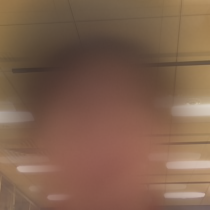

In [3]:
imgArray = None
for fname in fnames:
    im = Image.open(fname)
    if type(imgArray) == type(None):
        imgArray = np.asarray(im)/len(fnames)
    else:
        imgArray += np.asarray(im)/len(fnames)

pilImg = Image.fromarray(np.uint8(imgArray))
pilImg

# データセットを加工する

In [4]:
from chainer.datasets import TransformDataset
from PIL import Image

width, height = 224, 224

# 平均画像を用意する
imgArray = None
for fname in fnames:
    img = Image.open(fname)
    img = img.resize((width, height), Image.BICUBIC)
    im = np.asarray(img, dtype=np.float32).transpose(2, 0, 1)
    if type(imgArray) == type(None):
        imgArray = np.asarray(im)/len(fnames)
    else:
        imgArray += np.asarray(im)/len(fnames)
mean_image = imgArray.copy()

# 各データに行う変換
def transform(inputs):
    img, label = inputs
    img = img[:3, ...]
    img = img.astype(np.uint8)
    img = Image.fromarray(img.transpose(1, 2, 0))
    img = img.resize((width, height), Image.BICUBIC)
    img = np.asarray(img, dtype=np.float32).transpose(2, 0, 1)
    img = img - mean_image
    return img, label

# 変換付きデータセットにする
td = TransformDataset(d, transform)

In [5]:
from chainer import datasets

train_img, valid_img = datasets.split_dataset_random(td, int(len(d) * 0.8), seed=0)

# モデルの読み込み

In [6]:
%%time
MODEL = 'model/bvlc_googlenet.caffemodel'
PICKLE = 'model/ggnet.pkl'
if os.path.exists(PICKLE):
    print("Load pickle")
    with open(PICKLE, 'rb') as pkl:
        model = pickle.load(pkl)
else:
    print("Load caffemodel and make pickle")
    if os.path.exists(MODEL):
        model = CaffeFunction(MODEL)
        with open(PICKLE, 'wb') as pkl:
            pickle.dump(model, pkl)
    print(MODEL + " not found.")

Load caffemodel and make pickle
model/bvlc_googlenet.caffemodel not found.
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 323 µs


# GoogLeNetのモデル

In [7]:
class GoogLeNet(Chain):
    insize = 224
    
    def __init__(self):
        super(GoogLeNet, self).__init__()
        with self.init_scope():
            self.conv1 =  L.Convolution2D(3, 64, 7, stride=2, pad=3)
            self.conv2_reduce = L.Convolution2D(64, 64, 1)
            self.conv2 = L.Convolution2D(64, 192, 3, stride=1, pad=1)
            self.inception_3a = L.Inception(192, 64, 96, 128, 16, 32, 32)
            self.inception_3b = L.Inception(256, 128, 128, 192, 32, 96, 64)
            self.inception_4a = L.Inception(480, 192, 96, 208, 16, 48, 64)
            self.inception_4b = L.Inception(512, 160, 112, 224, 24, 64, 64)
            self.inception_4c = L.Inception(512, 128, 128, 256, 24, 64, 64)
            self.inception_4d = L.Inception(512, 112, 144, 288, 32, 64, 64)
            self.inception_4e = L.Inception(528, 256, 160, 320, 32, 128, 128)
            self.inception_5a = L.Inception(832, 256, 160, 320, 32, 128, 128)
            self.inception_5b = L.Inception(832, 384, 192, 384, 48, 128, 128)
            self.loss3_fc = L.Linear(1024, 1000)
            
            self.loss1_conv = L.Convolution2D(512, 128, 1)
            self.loss1_fc1 = L.Linear(2048, 1024)
            self.loss1_fc2 = L.Linear(1024, 1000)
            
            self.loss2_conv = L.Convolution2D(528, 128, 1)
            self.loss2_fc1 = L.Linear(2048, 1024)
            self.loss2_fc2 = L.Linear(1024, 1000)
        
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 3, stride=2)
        h = F.local_response_normalization(h, n=5, k=1, alpha=2e-05)
        h = F.relu(self.conv2_reduce(h))
        h = F.relu(self.conv2(h))
        h = F.local_response_normalization(h, n=5, k=1, alpha=2e-05)
        h = F.max_pooling_2d(h, 3, stride=2)
        
        h = self.inception_3a(h)
        h = self.inception_3b(h)
        h = F.max_pooling_2d(h, 3, stride=2)
        h = self.inception_4a(h)
        
        b = F.average_pooling_2d(h, 5, stride=3)
        b = F.relu(self.loss1_conv(b))
        b = F.relu(self.loss1_fc1(b))
        b = self.loss1_fc2(b)
        
        h = self.inception_4b(h)
        h = self.inception_4c(h)
        h = self.inception_4d(h)
        
        b = F.average_pooling_2d(h, 5, stride=3)
        b = F.relu(self.loss2_conv(b))
        b = F.relu(self.loss2_fc1(b))
        b = self.loss2_fc2(b)
        
        h = self.inception_4e(h)
        h = F.max_pooling_2d(h, 3, stride=2)
        h = self.inception_5a(h)
        h = self.inception_5b(h)
        
        h = F.average_pooling_2d(h, 7, stride=1)
        y = self.loss3_fc(F.dropout(h, 0.4))
        return y

In [8]:
train = train_img
test = valid_img
model = L.Classifier(GoogLeNet())

In [10]:

dev = 0
if dev >= 0:
    chainer.cuda.get_device(dev).use()
    model.to_gpu()

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

train_iter = chainer.iterators.SerialIterator(train, 100)
test_iter = chainer.iterators.SerialIterator(test, 100, repeat=False, shuffle=False)

epoch = 1000
updater = training.StandardUpdater(train_iter, optimizer, device=dev)
trainer = training.Trainer(updater, (epoch, 'epoch'), out="result")

# Evaluator
trainer.extend(extensions.Evaluator(test_iter, model, device=dev))

# LogReport
trainer.extend(extensions.LogReport())

# PrintReport
trainer.extend(extensions.PrintReport( entries=['epoch', 'main/loss', 'main/accuracy','validation/main/loss', 'validation/main/accuracy', 'elapsed_time' ]))

print("run")
trainer.run()

run
epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.0593657   0.983626       1.35549               0.841661                  256.261       
2           0.0521576   0.98696        1.44078               0.837608                  398.256       
3           0.060879    0.983977       1.25726               0.849601                  493.733       
4           0.0516174   0.986433       1.27983               0.837741                  588.89        
5           0.0596313   0.984235       1.20535               0.84701                   683.99        
6           0.0748191   0.980702       1.14182               0.837209                  779.314       
7           0.0649904   0.981813       1.06824               0.841429                  879.226       
8           0.0397576   0.988012       1.16501               0.847807                  990.91        
9           0.0356255   0.989884       1.17029               0.849734           

79          0.050935    0.98655        1.26237               0.844817                  7211.67       
80          0.044119    0.987648       1.15287               0.847375                  7298.6        
81          0.0362532   0.988421       1.2759                0.849402                  7386.02       
82          0.0586438   0.985381       1.2236                0.825615                  7473.42       
83          0.0440362   0.987427       1.38825               0.839402                  7560.74       
84          0.0823654   0.979884       1.31514               0.836578                  7648.12       
85          0.0655691   0.98406        1.32942               0.837708                  7735.03       
86          0.0751563   0.982281       1.14802               0.844219                  7822.66       
87          0.0604687   0.984211       1.14893               0.843289                  7910.11       
88          0.0487878   0.986901       1.13597               0.846877             

158         0.0467958   0.98655        1.38882               0.832957                  14079.6       
159         0.0421826   0.988773       1.30947               0.83                      14166.3       
160         0.0677944   0.98406        1.43069               0.838937                  14252.5       
161         0.0710203   0.982457       1.3807                0.836778                  14339.2       
162         0.0544058   0.985673       1.38753               0.832126                  14426.1       
163         0.0599786   0.984269       1.47424               0.830166                  14512.9       
164         0.0753436   0.981521       1.18385               0.835615                  14599.8       
165         0.048393    0.987589       1.20988               0.841329                  14686.1       
166         0.0284722   0.992164       1.3403                0.856711                  14772.6       
167         0.0346134   0.990994       1.44413               0.837973             

237         0.057794    0.986608       1.43714               0.842791                  20907.4       
238         0.0619598   0.985615       1.42743               0.843555                  20994         
239         0.085105    0.979708       1.26986               0.839136                  21080.5       
240         0.0424452   0.988647       1.3921                0.842326                  21166.6       
241         0.0415605   0.988948       1.4041                0.838771                  21253.2       
242         0.0644023   0.984387       1.36515               0.835482                  21339.7       
243         0.0541512   0.985381       1.3831                0.850033                  21426.1       
244         0.0450065   0.988714       1.21654               0.848106                  21512.6       
245         0.0703124   0.982942       1.25599               0.843289                  21598.7       
246         0.0556419   0.98579        1.31478               0.840731             

316         0.0453549   0.987135       1.33961               0.849203                  27731.2       
317         0.0467932   0.98848        1.32403               0.842691                  27817.6       
318         0.0588016   0.986492       1.39536               0.845349                  27904.1       
319         0.0383629   0.988948       1.43413               0.846545                  27990.5       
320         0.0503672   0.987706       1.44111               0.822824                  28076.5       
321         0.0633767   0.983977       1.61367               0.839203                  28162.9       
322         0.063887    0.985263       1.49866               0.828505                  28249.3       
323         0.0601427   0.984737       1.50511               0.845482                  28335.7       
324         0.0499217   0.987134       1.60309               0.83701                   28422.2       
325         0.0645557   0.984471       1.48733               0.843422             

395         0.0818112   0.981942       1.38712               0.822326                  34555.2       
396         0.0523222   0.986141       1.46116               0.840731                  34641.7       
397         0.0404036   0.989006       1.6058                0.847043                  34728.1       
398         0.0428334   0.988773       1.59447               0.834153                  34814.5       
399         0.0503217   0.987135       1.3176                0.843422                  34900.9       
400         0.0332422   0.991589       1.4852                0.830532                  34986.9       
401         0.0480711   0.987603       1.38781               0.838239                  35073.3       
402         0.0401623   0.989415       1.50055               0.844618                  35159.7       
403         0.0536806   0.987252       1.40378               0.840299                  35246.1       
404         0.0684487   0.982222       1.42419               0.839369             

474         0.0350861   0.991053       1.3839                0.846877                  41380         
475         0.0487732   0.986883       1.28828               0.844884                  41466         
476         0.0266501   0.992632       1.38804               0.840266                  41552.5       
477         0.0297016   0.992574       1.4368                0.846778                  41638.9       
478         0.056166    0.987311       1.54528               0.837641                  41725.4       
479         0.0885401   0.980527       1.54653               0.83887                   41811.9       
480         0.149615    0.980471       1.59574               0.770698                  41898.4       
481         0.13695     0.965439       1.42629               0.819734                  41984.8       
482         0.0686148   0.982282       1.38168               0.838904                  42071.3       
483         0.0544883   0.98696        1.28792               0.838671             

553         0.0496029   0.988305       1.57798               0.840997                  48242.5       
554         0.0521976   0.98731        1.53452               0.836445                  48330.9       
555         0.0506581   0.987883       1.64741               0.828439                  48418.8       
556         0.0615578   0.985322       1.46724               0.838737                  48507.1       
557         0.0567499   0.98579        1.39702               0.840332                  48595.7       
558         0.053748    0.987661       1.86909               0.830133                  48684         
559         0.085925    0.982047       1.70195               0.807176                  48772.4       
560         0.0747762   0.983118       1.42695               0.830399                  48860.3       
561         0.0517817   0.986725       1.58595               0.833256                  48948.9       
562         0.0493439   0.987778       1.49496               0.824419             

632         0.0360563   0.991404       1.47292               0.83505                   55233.6       
633         0.0372247   0.990351       1.61964               0.825515                  55322.7       
634         0.0500935   0.988305       1.62785               0.835083                  55411.8       
635         0.0390982   0.989294       1.75026               0.834053                  55500.4       
636         0.0799008   0.982457       1.71727               0.80907                   55589.3       
637         0.125696    0.972515       1.58904               0.828173                  55678.4       
638         0.0695557   0.983509       1.51562               0.835216                  55767.4       
639         0.0601997   0.984328       1.73474               0.830897                  55856.5       
640         0.0622574   0.986001       1.58943               0.832259                  55945.2       
641         0.0507147   0.986024       1.78071               0.83784              

711         0.03752     0.991579       1.74695               0.833754                  62259.7       
712         0.229798    0.957895       1.67075               0.791096                  62348.4       
713         0.119334    0.96965        1.48871               0.82299                   62437.1       
714         0.0606562   0.984562       1.66587               0.813688                  62525.8       
715         0.057347    0.984824       1.57158               0.831661                  62614         
716         0.0465002   0.98848        1.90066               0.829834                  62702.8       
717         0.0715488   0.983509       1.61123               0.822492                  62933.9       
718         0.0451272   0.988948       1.72875               0.838272                  63029.8       
719         0.0324753   0.991287       1.53941               0.840266                  63117.5       
720         0.0300087   0.991883       1.73514               0.837309             

790         0.0460764   0.988647       1.7137                0.83598                   69419.1       
791         0.0546277   0.987369       1.45795               0.840897                  69508.1       
792         0.0349718   0.99           1.68127               0.832625                  69597.2       
793         0.0552623   0.987544       1.81264               0.827807                  69686.3       
794         0.0704705   0.984795       1.8648                0.829535                  69776         
795         0.0704028   0.985471       1.83789               0.823788                  69865.3       
796         0.103267    0.979182       1.66144               0.834684                  69954.7       
797         0.0556984   0.985556       1.56123               0.839568                  70044.1       
798         0.0554842   0.988772       1.61928               0.835382                  70133.1       
799         0.0438805   0.989942       1.51017               0.831794             

869         0.0457838   0.988714       1.69603               0.832857                  76420.7       
870         0.0432371   0.98953        1.59595               0.84412                   76508.7       
871         0.0411669   0.990468       1.643                 0.832126                  76597.2       
872         0.0363518   0.990936       1.8448                0.834618                  76685.6       
873         0.075571    0.984153       1.76519               0.827575                  76774.1       
874         0.0464459   0.988889       1.64005               0.835648                  76862.6       
875         0.0470676   0.989236       1.71573               0.827176                  76950.6       
876         0.0756407   0.984211       1.83603               0.830797                  77039.2       
877         0.057014    0.986784       1.88273               0.841129                  77127.7       
878         0.0587728   0.986609       1.72706               0.837276             

948         0.0528561   0.988305       1.61064               0.845515                  83432         
949         0.0370228   0.991404       1.75357               0.840598                  83522.8       
950         0.052416    0.988824       1.79203               0.825515                  83611.9       
951         0.0389315   0.991462       1.729                 0.843854                  83701.3       
952         0.0417486   0.990936       1.73564               0.843189                  83790.7       
953         0.0394018   0.990585       1.74831               0.839236                  83880.1       
954         0.055291    0.98731        1.83392               0.839468                  83969.6       
955         0.0621926   0.988177       2.11274               0.829003                  84058.7       
956         0.0765593   0.983334       1.81859               0.847209                  84148.1       
957         0.0403995   0.990995       1.62852               0.841196             

In [11]:
model.to_cpu()
chainer.serializers.save_npz('result/2000epoch.npz', model)